# Colab hardware details

In [1]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


# Set paths and import all required modules

In [0]:
from pathlib import Path
import os ,sys, gc ,tarfile ,zipfile,pickle

homepath = Path('/content/drive/My Drive/EVA4/S15')
scripts  = Path('/content/drive/My Drive/EVA4/S15/scripts')
dataset  = Path('/content/drive/My Drive/EVA4/S15/dataset/pklFiles/')

os.chdir(homepath)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from IPython.core.debugger import set_trace

from torchvision.utils import make_grid
from torchsummary import summary
from PIL import Image
# New 
from torchvision import models

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# Load dataset from pkl

In [0]:
# extract tar.gz file 
archive_name = "/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test.tar.gz"
file_name    = "data_batch_64_test"

tar = tarfile.open(archive_name, "r:gz")

tar.extract(file_name, os.path.join(dataset,file_name))

pklfile = r'/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test/data_batch_64_test'

## Transformations

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        bgfg, bgfgM = sample['bgfg'], sample['bgfgM']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        #set_trace()
        #bgfg.resize(3,224,224)
        #bgfgM.resize(224,224)
        
        #bgfg = bgfg.transpose((1,2,0))
        #bgfgM = bgfgM.transpose((1,2,0))
        
        return {'bgfg': torch.from_numpy(bgfg),
                'bgfgM': torch.from_numpy(bgfgM)}

In [0]:
from torch.utils.data import Dataset,IterableDataset

class customDataset(IterableDataset):
    '''This class is about to read custom data from pkl file'''
    def __init__(self, pklfile, root_dir, dsKey = None,transform=None):
        """
        Args:
            pklfile (string): Path to the pkl file .
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        super(customDataset).__init__()
        self.pklfile    = pklfile
        self.root_dir   = root_dir
        self.transform  = transform
        self.dsKey      = dsKey
        self.customData = self.unpickle(self.pklfile)

    def __len__(self):
        #print((len(self.customData['bg_fg_1'])+len(self.customData['bg_fgFlip_1'])))
        return (len(self.customData['bgfg'])+len(self.customData['bgfgM']))


    def unpickle(self,file):
        with open(self.pklfile, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        b_img, m_img    = self.customData['bgfg'][idx], self.customData['bgfgM'][idx]
        #set_trace()
        b_img.resize(3,224,224)
        m_img.resize(224,224)

        if self.transform is None:
            ## To PIL image
            bgfgImg,maskImg = Image.fromarray(b_img.transpose(1,2,0),'RGB') , Image.fromarray(m_img)
            sample = {'bgfg': bgfgImg, 'bgfgM': maskImg}
            
        elif self.transform:
            ## In ND array
            #b_img.resize(3,224,224)
            #m_img.resize(224,224)
            sample = {'bgfg': b_img, 'bgfgM': m_img}
            sample = self.transform(sample)
        
        return sample

    def __iter__(self):
        print('hit')
        return iter(
            (self.__getitem__(i) for i in range(
                len(self.customData[self.dsKey])
                )
            )
        )

    

# Suman practice

In [0]:
import torch
from torchvision import transforms

transformed_dataset = customDataset(pklfile  = r'/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test/data_batch_64_test',
                    root_dir = r'/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test',
                    dsKey = 'bgfg',
                    transform=transforms.Compose([
                                               #Rescale(256),
                                               #RandomCrop(224),
                                               ToTensor()
                                           ])
                )

data_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=3,
                        shuffle=True, num_workers=3)

In [16]:
for i,j in enumerate(data_loader):
    print(i,j.keys())

IndexError: ignored

In [27]:
bgfg_imgs

'bgfg'

In [24]:
mask_imgs

'bgfgM'

## Display few images from the dataset

In [0]:
cds = customDataset(pklfile  = r'/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test/data_batch_64_test',
                    root_dir = r'/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test')
cds.customData.keys()

In [0]:
from matplotlib import pyplot as plt
def show_imgs(**img_mask):
    #print('Image label is : {}'.format(train_ds.classes[label]))
    img = img_mask['bgfg']
    mask = img_mask['bgfgM']
    
    plt.imshow(img)
    #plt.imshow(mask,cmap='Greys')


In [0]:
fig = plt.figure()
for i in range(len(cds)):
    sample = cds[i]

    #print(i, sample['bgfg'], sample['bgfgM'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_imgs(**sample)

    if i == 3:
        plt.show()
        break

## Transformations

In [28]:
import torch
from torchvision import transforms

transformed_dataset = customDataset(pklfile  = r'/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test/data_batch_64_test',
                    root_dir = r'/content/drive/My Drive/EVA4/S15/dataset/pklFiles/data_batch_64_test',
                    transform=transforms.Compose([
                                               #Rescale(256),
                                               #RandomCrop(224),
                                               ToTensor()
                                           ])
                )

for i in range(len(transformed_dataset)):
    print(i)
    sample = transformed_dataset[i]

    print(i, sample['bgfg'].shape, sample['bgfgM'].shape)

    if i == 3:
        break

0
0 torch.Size([3, 224, 224]) torch.Size([224, 224])
1
1 torch.Size([3, 224, 224]) torch.Size([224, 224])
2
2 torch.Size([3, 224, 224]) torch.Size([224, 224])
3
3 torch.Size([3, 224, 224]) torch.Size([224, 224])


In [0]:
data_loader = torch.utils.data.DataLoader(transformed_dataset, batch_size=5,
                        shuffle=False, num_workers=4)

## Helper function to show a batch

In [0]:
data_loader.dataset.customData['bgfg']

0 torch.Size([3, 224, 224]) torch.Size([224, 224])
1 torch.Size([3, 224, 224]) torch.Size([224, 224])
2 torch.Size([3, 224, 224]) torch.Size([224, 224])
3 torch.Size([3, 224, 224]) torch.Size([224, 224])


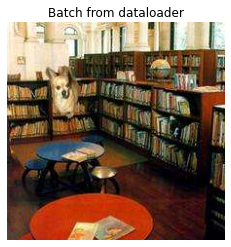

In [24]:
from torchvision import transforms, utils

def show_customDataset_batch(sample_batched):
    """Show image with BGFG for a batch of samples."""
    images_batch, mask_batch = \
            sample_batched['bgfg'], sample_batched['bgfgM']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        #set_trace()
        '''plt.scatter(mask_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    mask_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')
        
        plt.scatter(images_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    images_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')
        '''

        plt.title('Batch from dataloader')

for  i_batch,sample_batched in enumerate(data_loader.dataset):
    #set_trace()
    print(i_batch, sample_batched['bgfg'].shape,
          sample_batched['bgfgM'].shape)

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        
        show_customDataset_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [0]:
import torchvision

def show(tensors, figsize=(10, 10), *args, **kwargs):
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)
  grid_image = grid_tensor.permute(1,2,0)
  plt.figure(figsize=figsize)
  plt.imshow(grid_image)
  plt.xticks([])
  plt.yticks([])
  plt.show()

TypeError: ignored

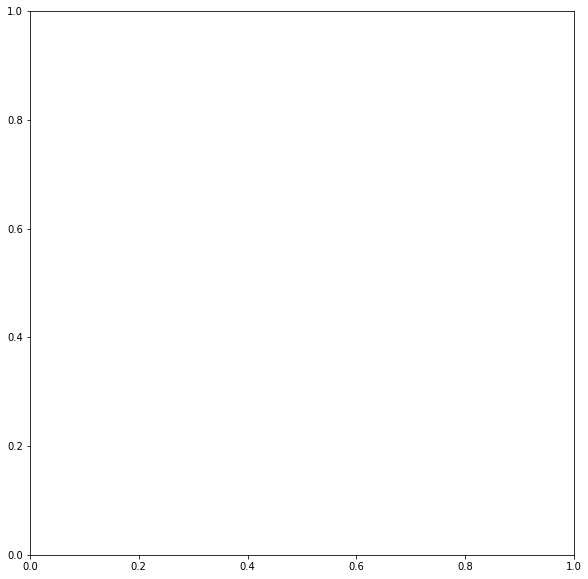

In [89]:
show(list(data_loader)[:5])

# Load model

In [66]:
type(transformed_dataset[4])

dict

##### U-Net


In [0]:
# Reference : https://raw.githubusercontent.com/usuyama/pytorch-unet/master/pytorch_unet.py
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, sample):
        bgfgs = sample['bg_fg']

        conv1 = self.dconv_down1(bgfgs)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        conv4d = self.dconv_down4(x)
       
        x = self.upsample(conv4)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        out1 = self.conv_last(x)
        # print('out-1: {}'.format(out1.shape))
        
        # Second output
        # print('conv-4-2nd : {}'.format(conv4.shape))
        x1 = self.upsample(conv4d)        
        # print('x1-2nd: {}'.format(x1.shape))
        x1 = torch.cat([x1, conv3], dim=1)
        
        x1 = self.dconv_up3(x1)
        x1 = self.upsample(x1)        
        x1 = torch.cat([x1, conv2], dim=1)       

        x1 = self.dconv_up2(x1)
        x1 = self.upsample(x1)        
        x1 = torch.cat([x1, conv1], dim=1)   
        
        x1 = self.dconv_up1(x1)
        
        out2 = self.conv_last(x)
        # print('out-2: {}'.format(out2.shape))
        return out1, out2

time: 58.6 ms
